In [1]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import psycopg2 as py
import nltk
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score,roc_curve,confusion_matrix
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import re
import phonetics as ph
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import Pipeline,FeatureUnion
from joblib  import dump,load 
from sklearn.utils import resample
from sklearn.preprocessing import FunctionTransformer
import pyphen
import syllables
from sklearn.utils import resample
from sklearn.base import BaseEstimator,TransformerMixin
from features import NameFeature,CleanName
#from cleanname import CleanName

In [2]:


def connection():
#**********************************Define your data source connection here *************************************************    
    return name_df


In [3]:
def cleanfirstname(name):
    #remove names starting with 'cust', cust-019292020 etc
    try:
        if len(name)<3 or name[:4]=='cust':
            name='noname'
            
        #split the name , sometime firstname column also has surname
        name=name.split()[0]

        #remove occurences xxxxx,zzzzz,---,.....,@@ etc
        name=''.join(re.findall('[x|z|-]*([a-zA-Z]+?)[z|x|-]*',name))

        if not name.isalpha():
            name='noname'

        if len(name)<3:
            name='noname'
    except:
        print(name)
    
    return name

In [4]:
def gettrainingdata(name_df):
    name_df['cleansed_firstname']=name_df.firstname.apply(lambda x: cleanfirstname(x))
    name_df['firstletter']=name_df.cleansed_firstname.apply(lambda x:x[0] if len(x)>0 else '')
    
    #for each starting letter identify top 2000 names
    firstletter_name_df=name_df[name_df['cleansed_firstname']!='noname'].groupby(['firstletter','cleansed_firstname']).cnt.agg([('cnt','sum')]).reset_index()
    firstletter_name_top_2000_df=firstletter_name_df.groupby('firstletter').apply(lambda x:x.sort_values(by='cnt',ascending=False).head(2000))
    firstletter_name_top_2000_df.rename(columns={'firstletter':'firstletter_2'},inplace=True)
    firstletter_name_top_2000_df.reset_index(inplace=True)
    firstletter_name_top_2000_df.drop(columns=['firstletter_2','level_1'],inplace=True)
    
    #selecting propernames

    model_data=name_df.merge(firstletter_name_top_2000_df,on=['firstletter','cleansed_firstname'],how='inner')
    print("Total Population: {} , Cleasned firstname population: {}, Top 2000 firstname population: {}".format(name_df.cnt.sum(),firstletter_name_df.cnt.sum(),model_data.cnt_x.sum()))

    #unique firstname, gender combination #for each name, select top gender
    training_data=model_data.groupby(['cleansed_firstname','gender']).cnt_x.sum().reset_index()
    training_data= training_data.groupby('cleansed_firstname').apply(lambda x:x.sort_values(by='cnt_x',ascending=False).head(1))
    training_data.rename(columns={'cleansed_firstname':'cleansed_firstname_2'},inplace=True)
    training_data.reset_index(inplace=True)
    training_data.drop(columns=['cleansed_firstname_2','level_1'],inplace=True)
    
    le=LabelEncoder()
    training_data['gender']=le.fit_transform(training_data['gender'])

    gender_0_oversample=resample(training_data[training_data['gender']==1],n_samples=30000)
    gender_1_oversample=resample(training_data[training_data['gender']==0],n_samples=30000)
    training_data=pd.concat([gender_0_oversample,gender_1_oversample])

    X=training_data['cleansed_firstname']
    Y=training_data['gender']
    x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=42)

    return x_train,x_test,y_train,y_test

In [5]:
def getRoccurve(y_test,y_pred_proba):
    fpr,tpr,threshold=roc_curve(y_test,y_pred_proba)
    score=roc_auc_score(y_test,y_pred_proba)
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.plot(fpr,tpr,label='ROC Score %0.2f' %score)
    plt.legend(loc='lower right')
    
    plt.show()

In [6]:
def main():
    data=connection()
    x_train,x_test,y_train,y_test=gettrainingdata(data)
    
    pipeline=Pipeline(steps=[
                    ('cleaning',CleanName()),
                    ('features',NameFeature()),
                    ('dictvectorizer',DictVectorizer()),
                    ('model',RandomForestClassifier(n_estimators=100))])
    
    pipeline.fit(x_train,y_train)
    getRoccurve(y_test,pipeline.predict_proba(x_test)[:,1])
    print(classification_report(y_test,pipeline.predict(x_test)))
    
    dump(pipeline,filename="gender_classification.joblib")

Total Population: 514771852 , Cleasned firstname population: 484349431, Top 2000 firstname population: 406114992


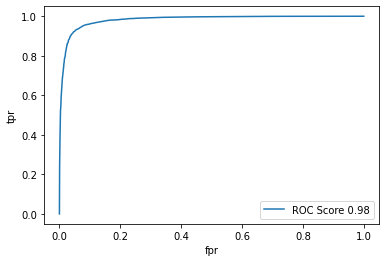

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      9056
           1       0.95      0.92      0.94      8944

    accuracy                           0.94     18000
   macro avg       0.94      0.94      0.94     18000
weighted avg       0.94      0.94      0.94     18000



In [7]:
if __name__ == "__main__":
    main()